# Week 6: kNN

First, import your libraries!

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from matplotlib import pyplot as plt
from sklearn import preprocessing

## Data prep

Based on the following data summary, what questions and business metric should we use? 

In [2]:
bank_data = pd.read_csv("https://raw.githubusercontent.com/UVADS/DS-3001/main/data/bank.csv")
bank_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43628 entries, 0 to 43627
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        43628 non-null  int64 
 1   job        43628 non-null  object
 2   marital    43628 non-null  object
 3   education  43628 non-null  object
 4   default    43628 non-null  object
 5   balance    43628 non-null  int64 
 6   housing    43628 non-null  object
 7   contact    43628 non-null  object
 8   duration   43628 non-null  int64 
 9   campaign   43628 non-null  int64 
 10  pdays      43628 non-null  int64 
 11  previous   43628 non-null  int64 
 12  poutcome   43628 non-null  object
 13  signed up  43628 non-null  int64 
dtypes: int64(7), object(7)
memory usage: 4.7+ MB


There is no missing data, there is 7 int type and 7 object type. Pandas doesn't know what object is, but knows not a number. 
Continuous model would be regression, so could do that with balance bc it is continuous. 
We are going to move the data into employed and unemployed. 

Now, let's check the composition of the data.

In [55]:
bank_data.marital.value_counts()   # 3 levels

marital
married     26241
single      12355
divorced     5032
Name: count, dtype: int64

In [56]:
bank_data.education.value_counts()   # 4 levels

education
secondary    22404
tertiary     12863
primary       6584
unknown       1777
Name: count, dtype: int64

In [57]:
bank_data.default.value_counts()   # 2 levels

default
no     42844
yes      784
Name: count, dtype: int64

In [58]:
bank_data.job.value_counts()   # 12 levels! What should we do?
#these category aren't very good rn, they are to specific.
#house maid is specific job, should 

job
blue-collar      9366
management       9142
technician       7321
admin.           5001
services         4010
retired          2184
self-employed    1530
entrepreneur     1433
unemployed       1259
housemaid        1199
student           907
unknown           276
Name: count, dtype: int64

In [59]:
bank_data.contact.value_counts()   # 3 levels -- difference between cellular and telephone?

contact
cellular     28295
unknown      12523
telephone     2810
Name: count, dtype: int64

In [60]:
bank_data.housing.value_counts()   # 2 levels

housing
yes    24231
no     19397
Name: count, dtype: int64

In [61]:
bank_data.poutcome.value_counts()   # 4 levels

poutcome
unknown    35684
failure     4723
other       1783
success     1438
Name: count, dtype: int64

In [62]:
bank_data['signed up'].value_counts()   # 2 levels

signed up
0    38554
1     5074
Name: count, dtype: int64

We should collapse the variable with 12 levels. In Python, this process is slightly different than it is in R.

In [63]:
employed = ['admin', 'blue-collar', 'entrepreneur', 'housemaid', 'management',
           'self-employed', 'services', 'technician']
# unemployed = ['student', 'unemployed', 'unknown']
bank_data.job = bank_data.job.apply(lambda x: "Employed" if x in employed else "Unemployed")
bank_data.job.value_counts()

job
Employed      34001
Unemployed     9627
Name: count, dtype: int64

Now, we convert the appropriate columns to factors.

In [64]:
# bank_data.info()   # check the variables
cat = ['job', 'marital', 'education', 'default', 'housing', 'contact',
      'poutcome', 'signed up']   # select the columns to convert
bank_data[cat] = bank_data[cat].astype('category')
bank_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43628 entries, 0 to 43627
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   age        43628 non-null  int64   
 1   job        43628 non-null  category
 2   marital    43628 non-null  category
 3   education  43628 non-null  category
 4   default    43628 non-null  category
 5   balance    43628 non-null  int64   
 6   housing    43628 non-null  category
 7   contact    43628 non-null  category
 8   duration   43628 non-null  int64   
 9   campaign   43628 non-null  int64   
 10  pdays      43628 non-null  int64   
 11  previous   43628 non-null  int64   
 12  poutcome   43628 non-null  category
 13  signed up  43628 non-null  category
dtypes: category(8), int64(6)
memory usage: 2.3 MB


### Check for missing data

R uses the mice package, which allows you to visualize the NaNs in a dataset and later impute it. There is no equivalent package in Python, but we can still complete the same steps.

Using the seaborn package, we can see the distribution of missing values. Along the x-axis, you will see the proportion of the data missing for that variable.

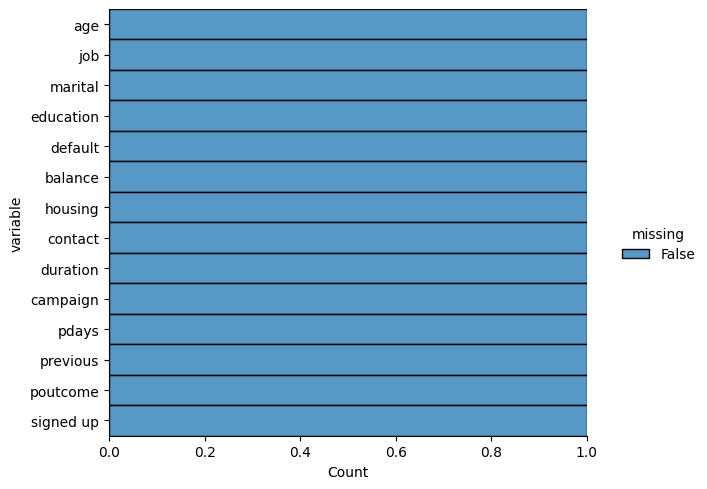

In [65]:
import seaborn as sns
sns.displot(
    data=bank_data.isna().melt(value_name="missing"),
    y="variable",
    hue="missing",
    multiple="fill",
    aspect=1.25
)
# plt.savefig("visualizing_missing_data_with_barplot_Seaborn_distplot.png", dpi=100)
# the above line will same the image to your computer!

**No missing data!!**

Next, we normalize the numeric variables. Do we always have to normalize numeric values within KNN
KNN uses equilian distance to determine the model. It uses the distance from two points. Can also you manhattan distance
Need to normalize when the data range of the data is different (weight and height)
Actual decision space needs to be edited. 

In [66]:
numeric_cols = bank_data.select_dtypes(include='int64').columns
print(numeric_cols)

Index(['age', 'balance', 'duration', 'campaign', 'pdays', 'previous'], dtype='object')


In [4]:
from sklearn import preprocessing
scaler = preprocessing.MinMaxScaler()
#transform the data so can use categorical ones, need to scale based on a 0 and 1 range 
#dummy variables turns them into 0 and 1, so they will all be in the same scale 
#numerical = now in range to 0-1
# categorical = now either 0 or 1
d = scaler.fit_transform(bank_data[numeric_cols])   # conduct data transformation
scaled_df = pd.DataFrame(d, columns=numeric_cols)   # convert back to pd df; transformation converts to array
bank_data[numeric_cols] = scaled_df   # put data back into the main df

NameError: name 'numeric_cols' is not defined

In [68]:
bank_data.describe()   # as we can see, the data is now normalized!

,age,balance,duration,campaign,pdays,previous
count,43628.000000,43628.000000,43628.000000,43628.000000,43628.000000,43628.000000
mean,0.297630,0.085120,0.052513,0.028516,0.047116,0.002110
std,0.137894,0.027623,0.052539,0.050099,0.114633,0.008443
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.194805,0.073448,0.020943,0.000000,0.000000,0.000000
50%,0.272727,0.076853,0.036600,0.016129,0.000000,0.000000
75%,0.389610,0.085714,0.064864,0.032258,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Now, we onehot encode the data -- for reference, this is the process of converting categorical variables to a usable form for a machine learning algorithm.

In [69]:
cat_cols = bank_data.select_dtypes(include='category').columns
print(cat_cols)

Index(['job', 'marital', 'education', 'default', 'housing', 'contact',
       'poutcome', 'signed up'],
      dtype='object')


In [70]:
encoded = pd.get_dummies(bank_data[cat_cols])
encoded.head()   # note the new columns

,job_Employed,job_Unemployed,marital_divorced,marital_married,marital_single,education_primary,education_secondary,education_tertiary,education_unknown,default_no,...,housing_yes,contact_cellular,contact_telephone,contact_unknown,poutcome_failure,poutcome_other,poutcome_success,poutcome_unknown,signed up_0,signed up_1
0,True,False,False,True,False,False,False,True,False,True,...,False,False,False,True,False,False,False,True,True,False
1,False,True,False,True,False,True,False,False,False,True,...,False,True,False,False,False,False,True,False,True,False
2,True,False,False,True,False,False,False,True,False,True,...,False,True,False,False,False,False,False,True,True,False
3,True,False,False,True,False,False,True,False,False,True,...,False,False,False,True,False,False,False,True,True,False
4,True,False,False,True,False,False,False,True,False,True,...,False,True,False,False,False,False,False,True,True,False


In [71]:
bank_data = bank_data.drop(cat_cols, axis=1)

In [72]:
bank_data = bank_data.join(encoded)

In [73]:
bank_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43628 entries, 0 to 43627
Data columns (total 28 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   age                  43628 non-null  float64
 1   balance              43628 non-null  float64
 2   duration             43628 non-null  float64
 3   campaign             43628 non-null  float64
 4   pdays                43628 non-null  float64
 5   previous             43628 non-null  float64
 6   job_Employed         43628 non-null  bool   
 7   job_Unemployed       43628 non-null  bool   
 8   marital_divorced     43628 non-null  bool   
 9   marital_married      43628 non-null  bool   
 10  marital_single       43628 non-null  bool   
 11  education_primary    43628 non-null  bool   
 12  education_secondary  43628 non-null  bool   
 13  education_tertiary   43628 non-null  bool   
 14  education_unknown    43628 non-null  bool   
 15  default_no           43628 non-null 

The data is ready! Now, let's build our model.

## Train model

We'll run the kNN algorithm on the banking data. First, we'll check the prevalence of the target class.

In [8]:
bank_data['signed up_1'].value_counts()[1] / bank_data['signed up_1'].count()

KeyError: 'signed up_1'

This means that at random, we have an 11.6% chance of correctly picking a subscribed individual. Let's see if kNN can do any better.

In [3]:
"""
X = bank_data.drop(['signed up_1'], axis=1).values   # independent variables
y = bank_data['signed up_1'].values                  # dependent variable
"""

def clean_and_split_data(df, target, test_size=0.4, val_size=0.5, random_state=1984):
    # Collapse 'job' levels
    employed = ['admin', 'blue-collar', 'entrepreneur', 'housemaid', 'management',
                'self-employed', 'services', 'technician']
    df.iloc[:, df.columns.get_loc('job')] = df.iloc[:, df.columns.get_loc('job')].apply(lambda x: "Employed" if x in employed else "Unemployed")
   
    # Convert appropriate columns to category
    cat_cols = ['job', 'marital', 'education', 'default', 'housing', 'contact', 'poutcome', target]
    df[cat_cols] = df[cat_cols].astype('category')
   
    # Normalize numeric columns
    numeric_cols = df.select_dtypes(include='int64').columns
    scaler = preprocessing.MinMaxScaler()
    df[numeric_cols] = scaler.fit_transform(df[numeric_cols])
   
    # One-hot encode categorical columns
    encoded = pd.get_dummies(df[cat_cols])
    df = df.drop(cat_cols, axis=1).join(encoded)
   
    # Split data into train, test, and validation sets
    train, test = train_test_split(df, test_size=test_size, stratify=df[f'{target}_1'], random_state=random_state)
    test, val = train_test_split(test, test_size=val_size, stratify=test[f'{target}_1'], random_state=random_state)
   
    return train, test, val
# Usage
train, test, val = clean_and_split_data(bank_data, 'signed up')

#train, test = train_test_split(bank_data,  test_size=0.4, stratify = bank_data['signed up_1']) 

In [5]:
test, val = train_test_split(test, test_size=0.5, stratify=test['signed up_1'])

Now, let's train the classifier for k=9.

In [6]:
import random
random.seed(1984)   # kNN is a random algorithm, so we use `random.seed(x)` to make results repeatable

X_train = train.drop(['signed up_1'], axis=1).values
y_train = train['signed up_1'].values

neigh = KNeighborsClassifier(n_neighbors=9)
neigh.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=9)

In [7]:
# now, we check the model's accuracy on the test data:

X_test = test.drop(['signed up_1'], axis=1).values
y_test = test['signed up_1'].values

neigh.score(X_test, y_test)

0.9857895943158377

In [8]:
# now, we test the accuracy on our validation data.

X_val = val.drop(['signed up_1'], axis=1).values
y_val = val['signed up_1'].values

neigh.score(X_val, y_val)

0.9867063946825578

## Evaluate model

A 99.0% accuracy rate is pretty good but keep in mind the baserate is roughly 89/11, so we have more or less a 90% chance of guessing right if we don't know anything about the customer, but the negative outcomes we don't really care about, this models value is being able to id sign ups when they are actually sign ups. This requires us to know are true positive rate, or Sensitivity or Recall. So let's dig a little deeper.   

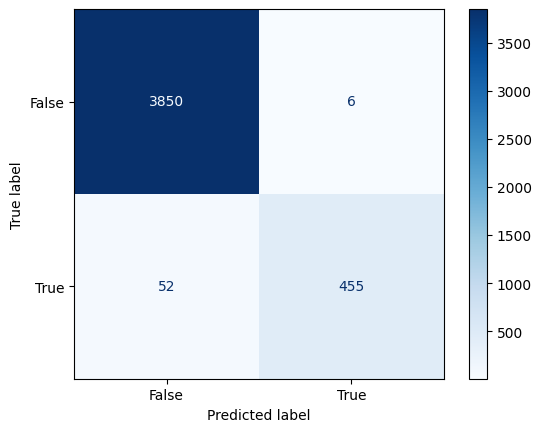

In [36]:
# create a confusion matrix
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_estimator(neigh, X_val, y_val, cmap='Blues')
plt.show()

*tip: use this link to change the color scheme of your confusion matrix: https://matplotlib.org/stable/tutorials/colors/colormaps.html*

In [10]:
# create classification report
from sklearn.metrics import classification_report

y_val_pred = neigh.predict(X_val)

In [11]:
print(classification_report(y_val_pred, y_val))

              precision    recall  f1-score   support

       False       1.00      0.99      0.99      3902
        True       0.90      0.99      0.94       461

    accuracy                           0.99      4363
   macro avg       0.95      0.99      0.97      4363
weighted avg       0.99      0.99      0.99      4363



In [12]:
# we didn't get sensitivity and specificity, so we'll calculate that ourselves.
sensitivity = 943/(943+72)   # = TP/(TP+FN)
specificity = 7707/(7707+4)   # = TN/(TN+FP)
print(sensitivity, specificity)

0.929064039408867 0.9994812605368953


#### Selecting the correct 'k'

How does "k" affect classification accuracy? Let's create a function to calculate classification accuracy based on the number of "k."

In [13]:
def chooseK(k, X_train, y_train, X_test, y_test):
    random.seed(1)
    print("calculating... ", k, "k")    # I'll include this so you can see the progress of the function as it runs
    class_knn = KNeighborsClassifier(n_neighbors=k)
    class_knn.fit(X_train, y_train)
    
    # calculate accuracy
    accu = class_knn.score(X_test, y_test)
    return accu

We'll test odd k values from 1 to 21. We want to create a table of all the data, so we'll use list comprehension to create the "accuracy" column. 

*remember: Python is end-exclusive; we want UP to 21 to we'll have to extend the end bound to include it*

In [ ]:
#overfitting bc the 
test = pd.DataFrame({'k':list(range(1,22,2)), 
                     'accu':[chooseK(x, X_train, y_train, X_test, y_test) for x in list(range(1, 22, 2))]})

calculating...  1 k
calculating...  3 k
calculating...  5 k
calculating...  7 k
calculating...  9 k
calculating...  11 k
calculating...  13 k
calculating...  15 k
calculating...  17 k
calculating...  19 k
calculating...  21 k


In [15]:
test

,k,accu
0,1,0.996104
1,3,0.993582
2,5,0.990603
3,7,0.988540
4,9,0.985790
5,11,0.986248
6,13,0.985560
7,15,0.983498
8,17,0.983727
9,19,0.981664


In [16]:
test = test.sort_values(by=['accu'], ascending=False)
test

,k,accu
0,1,0.996104
1,3,0.993582
2,5,0.990603
3,7,0.988540
5,11,0.986248
4,9,0.985790
6,13,0.985560
8,17,0.983727
7,15,0.983498
9,19,0.981664


**From here, we see that the best value of k=1!**

Let's go through the code we wrote in a bit more detail, specifically regarding the DataFrame construction.

For reference, here's the line of code we wrote:
```
test = pd.DataFrame({'k':list(range(1,22,2)), 
                     'accu':[chooseK(x, X_train, y_train, X_test, y_test) for x in list(range(1, 22, 2))]})
```

pandas DataFrames wrap around the Python dictionary data type, which is identifiable by the use of curly brackets ({}) and key-value pairs. The keys correspond to the column names (i.e. 'k' or 'accu') while the values are a list comprised of all the values we want to include. 

For 'k', we made a list of the range of numbers from 1 to 22 (end exclusive), selecting only every *other* value. This is done using the syntax: `range(first_val, end_val, by=?)`. Having no `by=` value means that we select every value in that range.

For 'accu', we used <a href=https://www.w3schools.com/python/python_lists_comprehension.asp>list comprehension</a>, which boils down to being loop shorthand with the output being entered into a list. We could easily re-write the code as:

```
temp = []
for x in list(range(1, 22, 2)):
    temp.append(chooseK(x, X_train, y_train, X_test, y_test))
```

before adding the list to the DataFrame. Evidently, the list comprehension saves time and memory, which is why we used it earlier.

#### Now, let's graph our results!

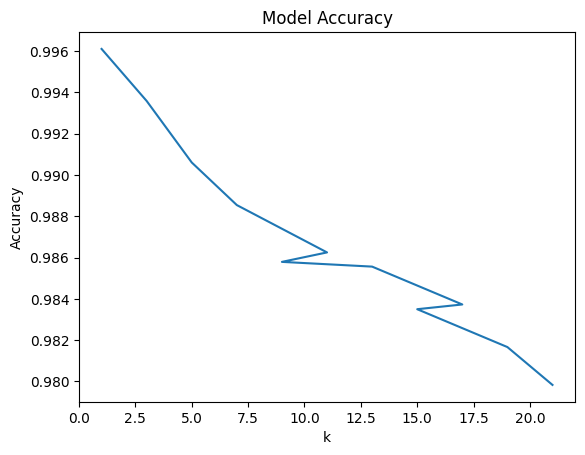

In [17]:
plt.plot(test['k'], test['accu'])
plt.xlabel('k')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')
plt.show()

## Adjusting the threshold

In [18]:
# we want to make a table containing: probability, expected, and actual values

test_probs = neigh.predict_proba(X_test)
test_preds = neigh.predict(X_test)

In [19]:
# convert probabilities to pd df
test_probabilities = pd.DataFrame(test_probs, columns = ['not_signed_up_prob', 'signed_up_prob'])
test_probabilities

,not_signed_up_prob,signed_up_prob
0,1.000000,0.000000
1,1.000000,0.000000
2,1.000000,0.000000
3,1.000000,0.000000
4,1.000000,0.000000
...,...,...
4358,1.000000,0.000000
4359,0.666667,0.333333
4360,1.000000,0.000000
4361,1.000000,0.000000


In [20]:
final_model = pd.DataFrame({'actual_class': y_test.tolist(),
                           'pred_class': test_preds.tolist(),
                           'pred_prob': [test_probabilities['signed_up_prob'][i] if test_preds[i]==1 else test_probabilities['not_signed_up_prob'][i] for i in range(len(test_preds))]})
# that last line is some list comprehension -- to understand that here in particular click the following link:
# https://stackoverflow.com/questions/4260280/if-else-in-a-list-comprehension

In [21]:
final_model.head()

,actual_class,pred_class,pred_prob
0,False,False,1.0
1,False,False,1.0
2,False,False,1.0
3,False,False,1.0
4,False,False,1.0


In [22]:
# add a column about the probability the observation is in the positive class
final_model['pos_pred'] = [final_model.pred_prob[i] if final_model.pred_class[i]==1 else 1-final_model.pred_prob[i] for i in range(len(final_model.pred_class))]

In [23]:
final_model.head()

,actual_class,pred_class,pred_prob,pos_pred
0,False,False,1.0,0.0
1,False,False,1.0,0.0
2,False,False,1.0,0.0
3,False,False,1.0,0.0
4,False,False,1.0,0.0


In [24]:
# convert classes to categories
final_model.actual_class = final_model.actual_class.astype('category')
final_model.pred_class = final_model.pred_class.astype('category')

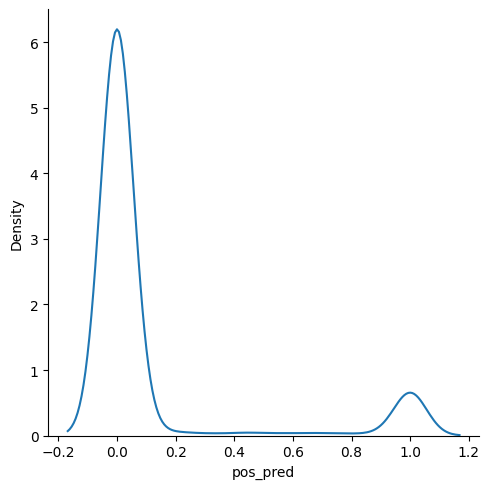

In [25]:
# create probability distribution graph
import seaborn as sns

sns.displot(final_model, x="pos_pred", kind="kde")

In [26]:
final_model.pos_pred.value_counts()

pos_pred
0.000000    3790
1.000000     399
0.111111      45
0.222222      24
0.444444      23
0.666667      20
0.555556      17
0.888889      15
0.333333      15
0.777778      15
Name: count, dtype: int64

In most datasets, the probabilities range between 0 and 1, causing uncertain predictions. A threshold must be set for where you consider the prediction to actually be a part of the positive class. Is a 60% certainty positive? How about 40%? This is where you have more control over your model's classifications. **This is especially useful for reducing incorrect classifications that you may have noticed in your confusion matrix.**

In [27]:
from sklearn.metrics import confusion_matrix

def adjust_thres(x, y, z):
    """
    x=pred_probabilities
    y=threshold
    z=tune_outcome
    """
    thres = pd.DataFrame({'new_preds': [1 if i > y else 0 for i in x]})
    thres.new_preds = thres.new_preds.astype('category')
    con_mat = confusion_matrix(z, thres)  
    print(con_mat)

In [28]:
confusion_matrix(final_model.actual_class, final_model.pred_class)   # original model

array([[3845,   10],
       [  52,  456]])

In [29]:
adjust_thres(final_model.pos_pred, .90, final_model.actual_class)   # raise threshold 

[[3855    0]
 [ 109  399]]


In [30]:
adjust_thres(final_model.pos_pred, .3, final_model.actual_class)   # lower threshold

[[3839   16]
 [  20  488]]


## More for next week: evaluation metrics

#### ROC/AUC curve
There are a few really cool graphing options, so I'll show you a few. There are several packages in Python are interactive as well!

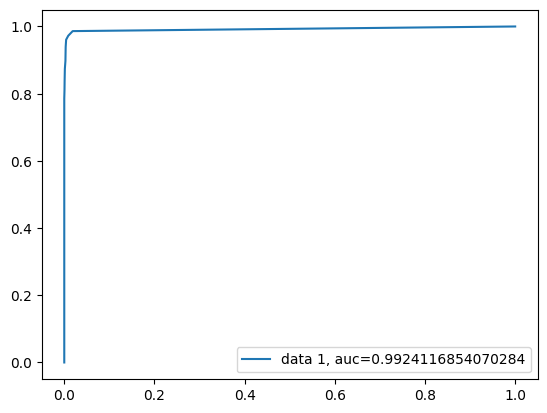

In [31]:
# basic graph
from sklearn import metrics

fpr, tpr, _ = metrics.roc_curve(y_test, final_model.pos_pred)
auc = metrics.roc_auc_score(y_test, final_model.pos_pred)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

In [32]:
# installs dependency for next graph
! pip install plot_metric

In [33]:
# a pretty cool one

from plot_metric.functions import BinaryClassification

# Visualisation with plot_metric
bc = BinaryClassification(y_test, final_model.pred_class, labels=["0", "1"])

# Figures
plt.figure(figsize=(5,5))
bc.plot_roc_curve()
plt.show()

ImportError: cannot import name 'interp' from 'scipy' (/opt/conda/lib/python3.10/site-packages/scipy/__init__.py)

#### F1 score

In [ ]:
metrics.f1_score(y_test, final_model.pred_class)

0.9571428571428572

#### LogLoss

In [ ]:
metrics.log_loss(y_test, final_model.pred_class)

0.3324848515189683

## Another quick example

In [ ]:
from pydataset import data

iris = data("iris")
iris.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 150 entries, 1 to 150
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Sepal.Length  150 non-null    float64
 1   Sepal.Width   150 non-null    float64
 2   Petal.Length  150 non-null    float64
 3   Petal.Width   150 non-null    float64
 4   Species       150 non-null    object 
dtypes: float64(4), object(1)
memory usage: 7.0+ KB


In [ ]:
iris.describe()

,Sepal.Length,Sepal.Width,Petal.Length,Petal.Width
count,150.000000,150.000000,150.000000,150.000000
mean,5.843333,3.057333,3.758000,1.199333
std,0.828066,0.435866,1.765298,0.762238
min,4.300000,2.000000,1.000000,0.100000
25%,5.100000,2.800000,1.600000,0.300000
50%,5.800000,3.000000,4.350000,1.300000
75%,6.400000,3.300000,5.100000,1.800000
max,7.900000,4.400000,6.900000,2.500000


In [ ]:
from sklearn.preprocessing import scale

cols = list(iris.columns[:4])

scaledIris = pd.DataFrame(scale(iris.iloc[:, :4]), index=iris.index, columns=cols)

In [ ]:
scaledIris.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 150 entries, 1 to 150
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Sepal.Length  150 non-null    float64
 1   Sepal.Width   150 non-null    float64
 2   Petal.Length  150 non-null    float64
 3   Petal.Width   150 non-null    float64
dtypes: float64(4)
memory usage: 5.9 KB


In [ ]:
scaledIris['Species'] = iris['Species']

In [ ]:
# split datasets
irisTrain, irisTest = train_test_split(scaledIris,  test_size=0.4, stratify = scaledIris['Species']) 
irisTest, irisVal = train_test_split(irisTest, test_size=0.5, stratify = irisTest['Species'])

In [ ]:
Xi_train = irisTrain.drop(['Species'], axis=1)
yi_train = irisTrain['Species']

Xi_test = irisTest.drop(['Species'], axis=1)
yi_test = irisTest['Species']

Xi_val = irisVal.drop(['Species'], axis=1)
yi_val = irisVal['Species']

In [ ]:
iris_neigh = KNeighborsClassifier(n_neighbors=3)
iris_neigh.fit(Xi_train, yi_train)

KNeighborsClassifier(n_neighbors=3)

In [ ]:
iris_neigh.score(Xi_test, yi_test)

0.9666666666666667

In [ ]:
iris_neigh.score(Xi_val, yi_val)

0.9

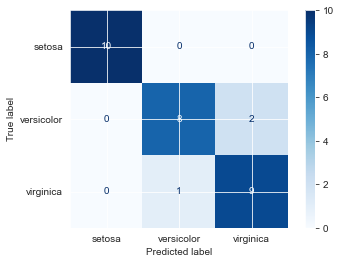

In [ ]:
plot_confusion_matrix(iris_neigh, Xi_val, yi_val, cmap='Blues')  
plt.show()

## Example using 10-k cross-validation 

In [ ]:
from sklearn.model_selection import RepeatedKFold

rkf = RepeatedKFold(n_splits=10, n_repeats=3, random_state=12) 

X_si = scaledIris.drop(['Species'], axis=1)
y_si = scaledIris['Species']

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

cv_neigh = KNeighborsClassifier(n_neighbors=3)   # create classifier
scores = cross_val_score(cv_neigh, X_si, y_si, scoring='accuracy', cv=rkf, n_jobs=-1)   # do repeated cv

print('Accuracy: %.3f (%.3f)' % (scores.mean(), scores.std()))

Accuracy: 0.949 (0.061)


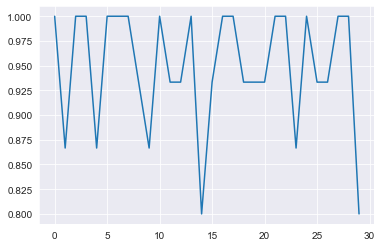

In [ ]:
plt.plot(scores)

Preliminary model score:
0.9666666666666667


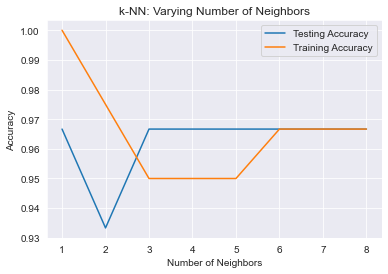

In [ ]:
# more complex version so you can create a graph for testing and training accuracy (not built into the previous version)

#Split arrays or matrices into train and test subsets
Xsi_train, Xsi_test, ysi_train, ysi_test = train_test_split(X_si, y_si, test_size=0.20) 
rcv_knn = KNeighborsClassifier(n_neighbors=6)
rcv_knn.fit(Xsi_train, ysi_train)

print("Preliminary model score:")
print(rcv_knn.score(Xsi_test, ysi_test))

no_neighbors = np.arange(1, 9)
train_accuracy = np.empty(len(no_neighbors))
test_accuracy = np.empty(len(no_neighbors))

for i, k in enumerate(no_neighbors):
    # We instantiate the classifier
    rcv_knn = KNeighborsClassifier(n_neighbors=k)
    # Fit the classifier to the training data
    rcv_knn.fit(Xsi_train, ysi_train)
    
    # Compute accuracy on the training set
    train_accuracy[i] = rcv_knn.score(Xsi_train, ysi_train)

    # Compute accuracy on the testing set
    test_accuracy[i] = rcv_knn.score(Xsi_test, ysi_test)

# Visualization of k values vs accuracy
plt.title('k-NN: Varying Number of Neighbors')
plt.plot(no_neighbors, test_accuracy, label = 'Testing Accuracy')
plt.plot(no_neighbors, train_accuracy, label = 'Training Accuracy')
plt.legend()
plt.xlabel('Number of Neighbors')
plt.ylabel('Accuracy')
plt.show()

### Variable importance

There is no easy way in SKLearn to calculate variable importance for a KNN model. So, we'll use a slightly hacked-together solution.

Variable importance reflects the significance one variable has on the model. If a variable is more important, that variable being removed/permuted has a larger effect on the output of the model. So, if we check the changes such permutations have, we should be able to extract the feature importance.

In [ ]:
data = {'sepal_length': [0], 'sepal_width': [0], 'petal_length': [0], 'petal_width': [0]}
feat_imp = pd.DataFrame(data)
feat_imp.head()

,sepal_length,sepal_width,petal_length,petal_width
0,0,0,0,0


0.9666666666666667


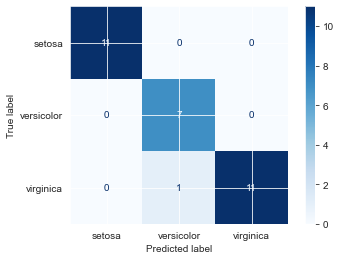

In [ ]:
# baseline

fin_knn = KNeighborsClassifier(n_neighbors=7)
fin_knn.fit(Xsi_train, ysi_train)

print(fin_knn.score(Xsi_test, ysi_test))
plot_confusion_matrix(fin_knn, Xsi_test, ysi_test, cmap='Blues')  

#### change `Sepal.Length`

In [ ]:
Xsi_test.head()

,Sepal.Length,Sepal.Width,Petal.Length,Petal.Width
144,1.159173,0.328414,1.217458,1.448832
149,0.432165,0.788808,0.933271,1.448832
56,-0.173674,-0.592373,0.421734,0.132510
5,-1.021849,1.249201,-1.340227,-1.315444
27,-1.021849,0.788808,-1.226552,-1.052180


In [ ]:
perm_SL = Xsi_test.copy()   # # copy df; we don't want to alter the actual data
perm_SL['Sepal.Length'] = np.random.permutation(perm_SL['Sepal.Length'])   # permute data
perm_SL.head()

,Sepal.Length,Sepal.Width,Petal.Length,Petal.Width
144,-0.900681,0.328414,1.217458,1.448832
149,-1.021849,0.788808,0.933271,1.448832
56,-0.900681,-0.592373,0.421734,0.132510
5,2.128516,1.249201,-1.340227,-1.315444
27,0.189830,0.788808,-1.226552,-1.052180


In [ ]:
fin_knn.score(perm_SL, ysi_test)

0.9

In [ ]:
feat_imp['sepal_length'] = fin_knn.score(Xsi_test, ysi_test) - fin_knn.score(perm_SL, ysi_test)
feat_imp.head()

,sepal_length,sepal_width,petal_length,petal_width
0,0.066667,0,0,0


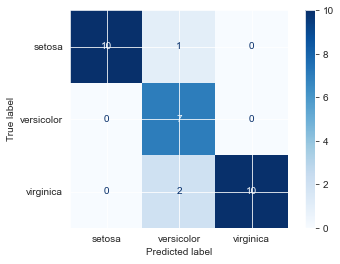

In [ ]:
plot_confusion_matrix(fin_knn, perm_SL, ysi_test, cmap='Blues')  # what got misclassified?

Instead of making this repetitive, we can turn this into a function and loop.

In [ ]:
def featureImportance(X, y, model):
    # create dataframe of variables
    var_imp = pd.DataFrame(columns=list(X.columns))
    var_imp.loc[0] = 0
    base_score = model.score(X, y)
    for col in list(X.columns):
        temp = X.copy()   # # copy df; we don't want to alter the actual data
        temp[col] = np.random.permutation(temp[col])   # permute data
        var_imp[col] = base_score - model.score(temp, y)
        # plot_confusion_matrix(model, temp, y, cmap='Blues')  # what got misclassified?
    print(var_imp)

In [ ]:
featureImportance(Xsi_test, ysi_test, fin_knn)

   Sepal.Length  Sepal.Width  Petal.Length  Petal.Width
0      0.033333          0.0           0.4     0.266667


From here, we find the important variables!

### General eval

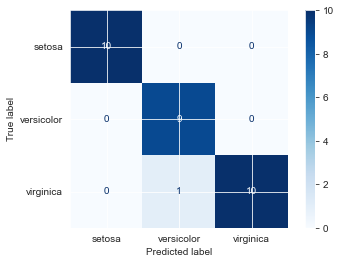

In [ ]:
plot_confusion_matrix(fin_knn, Xsi_test, ysi_test, cmap='Blues')  

Looks like we only misclassified one virginica as versicolor. Let's see how certain our predictions were.

In [ ]:
iris2_probs = fin_knn.predict_proba(Xsi_test)
iris2_probs

array([[0.        , 0.14285714, 0.85714286],
       [0.        , 0.28571429, 0.71428571],
       [0.        , 1.        , 0.        ],
       [0.        , 0.        , 1.        ],
       [1.        , 0.        , 0.        ],
       [0.        , 0.85714286, 0.14285714],
       [0.        , 1.        , 0.        ],
       [0.        , 0.28571429, 0.71428571],
       [0.        , 0.14285714, 0.85714286],
       [0.        , 0.28571429, 0.71428571],
       [0.        , 1.        , 0.        ],
       [1.        , 0.        , 0.        ],
       [1.        , 0.        , 0.        ],
       [1.        , 0.        , 0.        ],
       [0.        , 0.        , 1.        ],
       [0.        , 0.42857143, 0.57142857],
       [0.        , 0.71428571, 0.28571429],
       [0.        , 1.        , 0.        ],
       [1.        , 0.        , 0.        ],
       [0.        , 0.85714286, 0.14285714],
       [1.        , 0.        , 0.        ],
       [0.        , 1.        , 0.        ],
       [0.